In [10]:
%load_ext autoreload
%autoreload 2
%load_ext heat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The heat extension is already loaded. To reload it, use:
  %reload_ext heat


In [11]:
import ipas
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask
from mpl_toolkits.mplot3d import Axes3D
from shapely.ops import nearest_points
from pyquaternion import Quaternion
import copy as cp
from scipy import spatial 
from shapely.geometry import Point
from shapely.ops import nearest_points
import pandas as pd
from dask import dataframe as dd
import pickle
import scipy.stats as st
import datetime

In [13]:
cluster = SLURMCluster(
queue='kratos',
walltime='04-23:00:00',
cores=1,
memory='20000MiB', #1 GiB = 1,024 MiB
processes=1)

cluster.scale(20)
client = Client(cluster)
print(client)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://169.226.65.164:38833' processes=0 threads=0, memory=0 B>


In [48]:
client

()

In [17]:
def main():
    output = np.empty((len(phioarr),len(reqarr)),dtype=object)
    for phi in range(len(phioarr)):
        for r in range(len(reqarr)):
            output[phi,r] = dask.delayed(ipas.collect_clusters)(phioarr[phi], reqarr[r], nclusters, ncrystals,rand_orient)
            #ipas.collect_clusters(phioarr[phi], reqarr[r], nclusters, ncrystals,rand_orient)
    #delayeds = client.compute(delayeds)
    #output = client.gather(delayeds)
    
    return output

In [18]:
def compute():
    agg_as = np.empty((len(phioarr),len(reqarr), nclusters))
    agg_bs = np.empty((len(phioarr),len(reqarr), nclusters))
    agg_cs = np.empty((len(phioarr),len(reqarr), nclusters))
    phi2Ds = np.empty((len(phioarr),len(reqarr), nclusters))
    cplxs = np.empty((len(phioarr),len(reqarr), nclusters))
    dds = np.empty((len(phioarr),len(reqarr), nclusters))
    major_ax_zs = np.empty((len(phioarr),len(reqarr), nclusters))
    depths = np.empty((len(phioarr),len(reqarr), nclusters))
    
    gather = client.compute([*output.tolist()])  #only parallelizing agg r bins
    gather = client.gather(gather)

    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0,:]
    agg_bs = gather[:,:,1,:]
    agg_cs = gather[:,:,2,:]
    phi2Ds = gather[:,:,3,:]
    cplxs = gather[:,:,4,:] 
    dds = gather[:,:,5,:]
    major_ax_zs = gather[:,:,6,:]
    depths = gather[:,:,7,:]
    print('DONE!')
    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths

In [33]:
if __name__ == '__main__':
    phioarr=np.logspace(-2, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    #phioarr = [ .01, 0.1, 1.0, 10, 100]
    reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    #reqarr = [10]
    nclusters = 300         #changes how many aggregates per aspect ratio to consider
    ncrystals = 2
    rand_orient = False      #randomly orient the seed crystal and new crystal: uses first random orientation
    
    output = main()
    agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths = compute()

(20, 28, 8, 300)
DONE!


In [34]:
results = {'agg_as': agg_as, 'agg_bs':agg_bs, 'agg_cs':agg_cs, 'phi2Ds':phi2Ds, \
           'cplxs':cplxs, 'dds':dds, 'major_ax_zs':major_ax_zs, 'depths':depths}
filename = '../instance_files/instance_iceice_flat_rall_major_depth'
filehandler = open(filename, 'wb')
pickle.dump(results, filehandler)
filehandler.close()
print('finished!')

finished!


### LOAD DATA BACK IN

In [42]:
f = open('../instance_files/instance_iceice_rand_rall_major_depth', 'rb')
results = pickle.load(f)
agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths= \
                results['agg_as'], results['agg_bs'], results['agg_cs'], results['phi2Ds'], results['cplxs'], \
                results['dds'], results['major_ax_zs'], results['depths']
f.close()

In [43]:
def calculate_error(data, numaspectratios, ch):
    data[np.isinf(data)] = min(data)
    data[np.isnan(data)] = min(data)
    data= data[(data<np.quantile(data, .99)) & (data>np.quantile(data, .01))]
            
    mean = np.mean(data)
    std = np.std(data)
    shape = (mean/std)**2
    scale = (std**2)/mean
    shapech = mean/(numaspectratios*ch)

    pos_error = mean + std
    neg_error = mean - std

    min_data = min(data)
    max_data = max(data)

    return(pos_error, neg_error, min_data, max_data, mean)   

def mode_of_hist(data):
    data[np.isinf(data)] = min(data)
    data[np.isnan(data)] = min(data)
    data= data[(data<np.quantile(data, .99)) & (data>np.quantile(data, .01))]
    bins = (np.max(data) - np.min(data))/0.01
    n, bins, patches = plt.hist(data, bins=int(bins), density=True,
                                color='navy',range=(min(data), max(data)))
    mode = bins[np.where(n == np.max(n))]

    return mode[0]

def fit_distribution(data, normed = True, facecolor='navy', alpha=1.0, axes=None, **kwargs):
    data[np.isinf(data)] = min(data)
    data[np.isnan(data)] = min(data)
    data= data[(data<np.quantile(data, .99)) & (data>np.quantile(data, .01))]
    # Get histogram of original data
    y, x = np.histogram(data, density=True)
    fit_alpha, fit_loc, fit_beta=st.gamma.fit(data)
    pdf = st.gamma.pdf(x, a=fit_alpha, loc=fit_loc, scale=fit_beta)
    indmax = np.argmax(pdf) #FIRST index where the highest prob occurs
    gammach_ch = x[indmax] #characteristic of the distribution
    
    if axes is not None:
        n, bins, patches = plt.hist(data, bins=70, density=True,
                                color='navy',**kwargs)

        ax = plt.plot(x, pdf, lw=5, color='darkorange')
        plt.ylim(0,max(n))
        plt.show()

    return gammach_ch

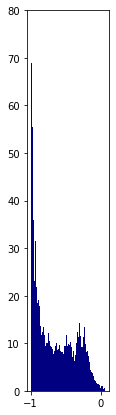

In [44]:
#find characteristic of gamma distribution
numaspectratios=len(agg_as[:,0,0])
numrs=len(agg_bs[0,:,0])
agg_cs_ch = np.empty((numaspectratios, numrs), dtype=np.float64) #major
agg_as_ch = np.empty((numaspectratios, numrs), dtype=np.float64) #minor
agg_as_mean = np.empty((numaspectratios, numrs), dtype=np.float64)
dds_mode = np.empty((numaspectratios, numrs), dtype=np.float64)
major_ax_zs_ch = np.empty((numaspectratios, numrs), dtype=np.float64)
major_ax_zs_mean = np.empty((numaspectratios, numrs), dtype=np.float64)
depths_ch = np.empty((numaspectratios, numrs), dtype=np.float64)

fig = plt.figure(figsize=(5,7))
ax = plt.subplot(131)

for i in range(numaspectratios):
    for r in range(numrs):
        #print(i,r)
        for c, data in enumerate([agg_cs, agg_as, dds, major_ax_zs, depths]):
        
            if c == 0:
                agg_cs_ch[i,r] = fit_distribution(data[i,r,:])
            if c == 1:
                agg_as_ch[i,r] = fit_distribution(data[i,r,:])
                pos_error, neg_error, min_data, max_data, agg_as_mean[i,r] = calculate_error(data[i,r,:], numaspectratios, agg_as_ch[i,r])
            if c == 2:
                #dds_ch[i,r] = fit_distribution(data[i,r,:])
                dds_mode[i,r] = mode_of_hist(data[i,r])
            if c == 3:
                major_ax_zs_ch[i,r] = fit_distribution(data[i,r,:])
                pos_error, neg_error, min_data, max_data, major_ax_zs_mean[i,r] = calculate_error(data[i,r,:], numaspectratios, major_ax_zs_ch[i,r])
            if c == 4:
                depths_ch[i,r] = fit_distribution(data[i,r,:])
                

In [40]:
#write to file for output as array:
with open("../lookup_tables/ice_ice/newformat_minorax_ellipsoid_flat_ch.dat","w") as file1:
    with open("../lookup_tables/ice_ice/newformat_majorax_ellipsoid_flat_ch.dat","w") as file2:
        with open("../lookup_tables/ice_ice/newformat_majorax_ellipsoid_flat_mean.dat","w") as file3:
            with open("../lookup_tables/ice_ice/newformat_dd_flat_mode.dat","w") as file4:
                with open ("../lookup_tables/ice_ice/newformat_majorax_ellipse_z_flat_ch.dat","w") as file5:
                    with open ("../lookup_tables/ice_ice/newformat_majorax_ellipse_z_flat_mean.dat","w") as file6:
                        with open ("../lookup_tables/ice_ice/newformat_depth_flat_ch.dat","w") as file7:
                        
                            file1.write('Ice-Ice collection for the flat orientation. \n'\
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                        'Order: phi, r, value \n')
                            
                            file2.write('Ice-Ice collection for the flat orientation. \n'
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                        'Order: phi, r, value \n')
                                
                            file3.write('Ice-Ice collection for the flat orientation. \n'
                                        'Mean value taken from the average across 300 aggregates. \n'\
                                        'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                        'Order: phi, r, value \n')
                                
                            file4.write('Ice-Ice collection for the flat orientation. \n'
                                        'Volume ratio of monomer (not 1.0) subtracted from volume ratio of agg (Vagg/Vellipse)\n'\
                                        'then normalized by the volume ratio of monomer. \n'\
                                        'Mode from 300 aggregates. \n'\
                                        'Order: phi, r, value \n')
                                
                            file5.write('Ice-Ice collection for the flat orientation. \n'\
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Major axis taken from a fit-ellipse (2D) in the z-orientation. \n'
                                        'Order: phi, r, value \n')
                                
                            file6.write('Ice-Ice collection for the flat orientation. \n'
                                        'Mean value taken from the average across 300 aggregates. \n'\
                                        'Major axis taken from a fit-ellipse (2D) in the z-orientation. \n'
                                        'Order: phi, r, value \n')
                                
                            file7.write('Ice-Ice collection for the flat orientation. \n'
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Depth measured as max z point - min z point. \n'
                                        'Order: phi, r, value \n')

                            for i in range(len(phioarr)):
                                for r in range(len(reqarr)):
                                    #print(i,r)
                                    file1.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_cs_ch[i,r]))
                                    file2.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_as_ch[i,r]))
                                    file3.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_as_mean[i,r]))
                                    file4.write('%.3f %.2f %.4f \n' %(phioarr[i], reqarr[r],  dds_mode[i,r]))
                                    file5.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  major_ax_zs_ch[i,r]))
                                    file6.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  major_ax_zs_mean[i,r]))
                                    file7.write('%.3f %.2f %.4f \n' %(phioarr[i], reqarr[r],  depths_ch[i,r]))

file1.close()
file2.close() 
file3.close()
file4.close()
file5.close()
file6.close()
file7.close()

In [45]:
#write to file for output as array:
with open("../lookup_tables/ice_ice/newformat_minorax_ellipsoid_rand_ch.dat","w") as file1:
    with open("../lookup_tables/ice_ice/newformat_majorax_ellipsoid_rand_ch.dat","w") as file2:
        with open("../lookup_tables/ice_ice/newformat_majorax_ellipsoid_rand_mean.dat","w") as file3:
            with open("../lookup_tables/ice_ice/newformat_dd_rand_mode.dat","w") as file4:
                with open ("../lookup_tables/ice_ice/newformat_majorax_ellipse_z_rand_ch.dat","w") as file5:
                    with open ("../lookup_tables/ice_ice/newformat_majorax_ellipse_z_rand_mean.dat","w") as file6:
                        with open ("../lookup_tables/ice_ice/newformat_depth_rand_ch.dat","w") as file7:
                        
                            file1.write('Ice-Ice collection for the random orientation. \n'\
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                        'Order: phi, r, value \n')
                            
                            file2.write('Ice-Ice collection for the random orientation. \n'
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                        'Order: phi, r, value \n')
                                
                            file3.write('Ice-Ice collection for the random orientation. \n'
                                        'Mean value taken from the average across 300 aggregates. \n'\
                                        'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                        'Order: phi, r, value \n')
                                
                            file4.write('Ice-Ice collection for the random orientation. \n'
                                        'Volume ratio of monomer (not 1.0) subtracted from volume ratio of agg (Vagg/Vellipse)..\n'\
                                        'then normalized by the volume ratio of monomer. \n'\
                                        'Mode from 300 aggregates. \n'\
                                        'Order: phi, r, value \n')
                                
                            file5.write('Ice-Ice collection for the random orientation. \n'\
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Major axis taken from a fit-ellipse (2D) in the z-orientation. \n'
                                        'Order: phi, r, value \n')
                                
                            file6.write('Ice-Ice collection for the random orientation. \n'
                                        'Mean value taken from the average across 300 aggregates. \n'\
                                        'Major axis taken from a fit-ellipse (2D) in the z-orientation. \n'
                                        'Order: phi, r, value \n')
                                
                            file7.write('Ice-Ice collection for the random orientation. \n'
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Depth measured as max z point - min z point. \n'
                                        'Order: phi, r, value \n')

                            for i in range(len(phioarr)):
                                for r in range(len(reqarr)):
                                    #print(i,r)
                                    file1.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_cs_ch[i,r]))
                                    file2.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_as_ch[i,r]))
                                    file3.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_as_mean[i,r]))
                                    file4.write('%.3f %.2f %.4f \n' %(phioarr[i], reqarr[r],  dds_mode[i,r]))
                                    file5.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  major_ax_zs_ch[i,r]))
                                    file6.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  major_ax_zs_mean[i,r]))
                                    file7.write('%.3f %.2f %.4f \n' %(phioarr[i], reqarr[r],  depths_ch[i,r]))

file1.close()
file2.close() 
file3.close()
file4.close()
file5.close()
file6.close()
file7.close()

In [41]:
df = pd.DataFrame(agg_cs_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_minorax_ellipsoid_flat_ch.dat', sep='\t')

df = pd.DataFrame(agg_as_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_majorax_ellipsoid_flat_ch.dat', sep='\t')

df = pd.DataFrame(agg_as_mean, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_majorax_ellipsoid_flat_mean.dat', sep='\t')

df = pd.DataFrame(dds_mode, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_dd_flat_mode.dat', sep='\t')

df = pd.DataFrame(major_ax_zs_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_majorax_ellipse_z_flat_ch.dat', sep='\t')

df = pd.DataFrame(major_ax_zs_mean, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_majorax_ellipse_z_flat_mean.dat', sep='\t')

df = pd.DataFrame(depths_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_depth_flat_ch.dat', sep='\t')


In [46]:
df = pd.DataFrame(agg_cs_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_minorax_ellipsoid_rand_ch.dat', sep='\t')

df = pd.DataFrame(agg_as_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_majorax_ellipsoid_rand_ch.dat', sep='\t')

df = pd.DataFrame(agg_as_mean, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_majorax_ellipsoid_rand_mean.dat', sep='\t')

df = pd.DataFrame(dds_mode, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_dd_rand_mode.dat', sep='\t')

df = pd.DataFrame(major_ax_zs_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_majorax_ellipse_z_rand_ch.dat', sep='\t')

df = pd.DataFrame(major_ax_zs_mean, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_majorax_ellipse_z_rand_mean.dat', sep='\t')

df = pd.DataFrame(depths_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/ice_ice/oldformat_depth_rand_ch.dat', sep='\t')
